In [2]:
import numpy as np
import matplotlib.pyplot as plt
# import torch
# from torch.autograd import Variable
import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw
# import torch.onnx

# from relaynet_pytorch.relay_net import ReLayNet
# from relaynet_pytorch.data_utils import get_imdb_data
# from helper import * # import helper functions

# from networks.relay_net import ReLayNet
# from networks.data_utils import get_imdb_data

# torch.set_default_tensor_type('torch.FloatTensor')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# For reading in datasets
# from torchvision.datasets import ImageFolder
# from torchvision import transforms, datasets

In [3]:
import os
cwd = os.getcwd() + '/datasets-24-aug/OCTData/alldata/'

In [4]:
# The values of the conversion by Elsa
values = [0.0, 0.007843138, 0.011764706, 0.015686275, 0.019607844, 0.023529412, 0.02745098]

In [5]:
import numpy
print (numpy.__version__)

1.15.1


(512, 600)


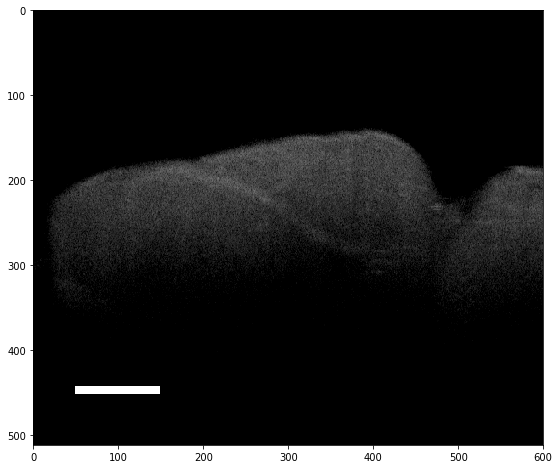

(512, 600, 3)


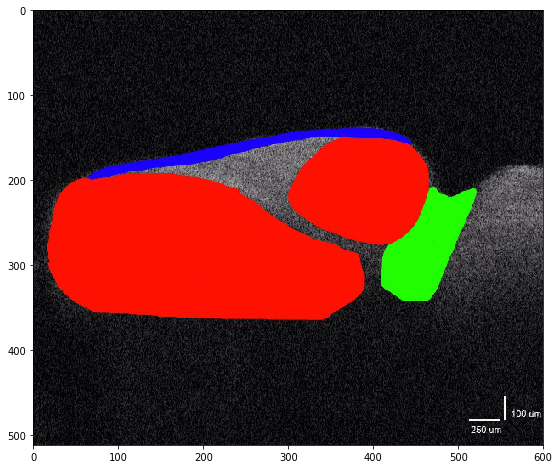

0 black
1 red
2 blue
3 purple
4 lime
5 orange
6 yellow
7 magenta
[0 1 3 7]
(512, 600)


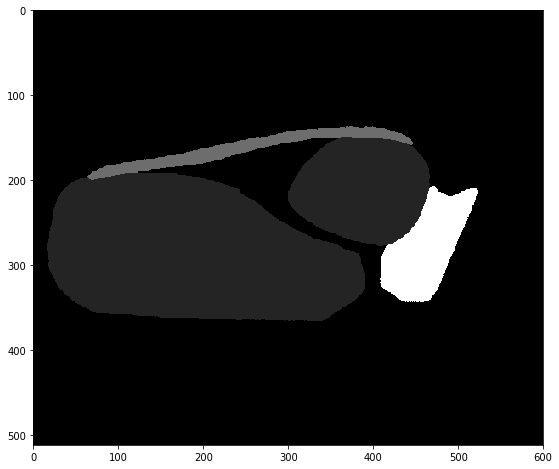

[0 1 3 5 7]
(512, 600)


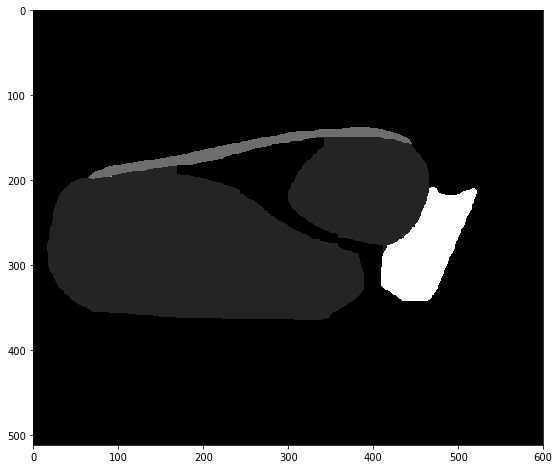

In [88]:
used_image = 1
if used_image == 1:
    image_file = 'whole_raw_image/con_H1_N01848_LV_1_194.tif'
    gnd_truth_image = 'manual_label/label_H1_N01848_LV_1_194.JPG'
    gnd_truth_label = 'png_labels_method/label_H1_N01848_LV_1_194_labels.png'
    result = 'labels_corrected/label_H1_N01848_LV_1_194_labelscorrected.png'
elif used_image == 2:
    image_file = 'whole_raw_image/con_H1_N01848_LA_1_272.tif'
    gnd_truth_image = 'manual_label/label_H1_N01848_LA_1_272.JPG'
    gnd_truth_label = 'png_labels_method/label_H1_N01848_LA_1_272_labels.png'
    result = 'labels_corrected/label_H1_N01848_LA_1_272_labelscorrected.png'

# Seeing whether image_file exists
raw_image_path = cwd + image_file
image = plt.imread(raw_image_path)
test_data = image    

print(test_data.shape)
plt.imshow(test_data,cmap = "gray")
# plt.imshow(test_data)
plt.show()

# Seeing whether labelled_image exists
label_image_path = cwd + gnd_truth_image
gnd_truth = plt.imread(label_image_path)
print(gnd_truth.shape)
plt.imshow(gnd_truth, cmap = "gray")
plt.show()

colors = [ 'black', 'red', 'blue', 'purple', 'lime', 'orange', 'yellow','magenta']
for count, i in enumerate(colors):
    print(count, i)
    
# Seeing whether result_image exists
gnd_truth_path = cwd + gnd_truth_label
gnd = plt.imread(gnd_truth_path)
gnd = ((gnd*7)/np.max(gnd)).astype(int)
print(np.unique(gnd))
print(gnd.shape)
plt.imshow(gnd,cmap = "gray")
plt.show()

# Seeing whether result_image exists
res_image_path = cwd + result
res = plt.imread(res_image_path)
res = ((res*7)/np.max(res)).astype(int)
print(np.unique(res))
print(res.shape)
plt.imshow(res,cmap = "gray")
plt.show()

# Metrics

File to generate metrics from each of the returned images.

* FP & FN
* Average Thickness of Layers - similar to MAD-LT below
* MAD-LT - error in estimated thickness map (ReLayNet Metric)
* DS - Dice Overlap Score (ReLayNet Metric)
* Distance (Euclidean) between Ground Truth and Where my Segments are - this is CE - Estimated contour error for each layer (ReLayNet Metric)

### False Positives & False Negatives per label

In [98]:
def list_of_labels(labels_list):
    val = 1
    h,w = labels_list.shape
    train_labels = np.zeros((h,w,8))
    for j in range(h) :
        for k in range(w):
            if(labels_list[j][k] == 0):
                train_labels[j][k][0] = val
            if(labels_list[j][k] == 1):
                train_labels[j][k][1] = val
            if(labels_list[j][k] == 2):
                train_labels[j][k][2] = val
            if(labels_list[j][k] == 3):
                train_labels[j][k][3] = val
            if(labels_list[j][k] == 4):
                train_labels[j][k][4] = val
            if(labels_list[j][k] == 5):
                train_labels[j][k][5] = val
            if(labels_list[j][k] == 6):
                train_labels[j][k][6] = val
            if(labels_list[j][k] == 7):
                train_labels[j][k][7] = val
    return train_labels
true_labels = list_of_labels(gnd)
pred_labels = list_of_labels(res)
# true_labels = np.zeros((512,600,8))

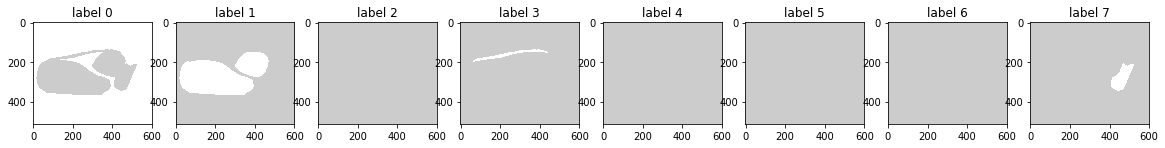

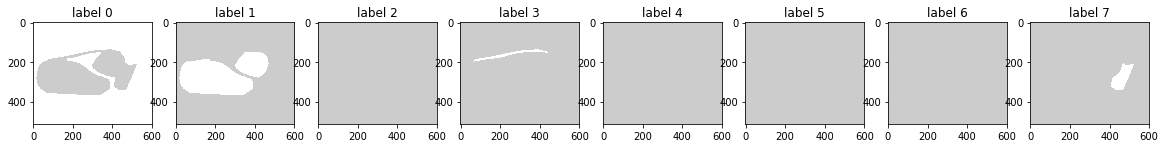

In [97]:
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(20,20))
for i, ax in enumerate(axes):
    ax.imshow((true_labels[:,:,i]), alpha=0.2)
    ax.set_title("label " + str(i))
    
fig, axes = plt.subplots(nrows=1, ncols=8, figsize=(20,20))
for i, ax in enumerate(axes):
    ax.imshow((pred_labels[:,:,i]), alpha=0.2)
    ax.set_title("label " + str(i))

In [114]:
num_classes = 8
class_vals = []
for i in range(num_classes):
    # NOTE: FOR MY CLASSES WITH MANY IMAGES - JUST ADD EXTRA DIMENSION TO pred_labels[x,:,:,i]

    # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
    TP = np.sum(np.logical_and(pred_labels[:,:,i] == 1, true_labels[:,:,i] == 1))
 
    # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
    TN = np.sum(np.logical_and(pred_labels[:,:,i] == 0, true_labels[:,:,i] == 0))
 
    # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
    FP = np.sum(np.logical_and(pred_labels[:,:,i] == 1, true_labels[:,:,i] == 0))
 
    # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
    FN = np.sum(np.logical_and(pred_labels[:,:,i] == 0, true_labels[:,:,i] == 1))

    Acc = (TP + TN)/(TP + TN + FP + FN)
    print('Label:',i)
    print('TP: {}, FP: {}, TN: {}, FN: {}, Class Accuracy: {}'.format(TP,FP,TN,FN,Acc))
    print()
    
    class_vals.append((TP,FP,TN,FN, Acc))

Label: 0
TP: 227101, FP: 1351, TN: 78353, FN: 395, Class Accuracy: 0.99431640625

Label: 1
TP: 65654, FP: 599, TN: 240438, FN: 509, Class Accuracy: 0.9963932291666666

Label: 2
TP: 0, FP: 0, TN: 307200, FN: 0, Class Accuracy: 1.0

Label: 3
TP: 4233, FP: 9, TN: 302178, FN: 780, Class Accuracy: 0.997431640625

Label: 4
TP: 0, FP: 0, TN: 307200, FN: 0, Class Accuracy: 1.0

Label: 5
TP: 0, FP: 1, TN: 307199, FN: 0, Class Accuracy: 0.9999967447916667

Label: 6
TP: 0, FP: 0, TN: 307200, FN: 0, Class Accuracy: 1.0

Label: 7
TP: 8246, FP: 6, TN: 298666, FN: 282, Class Accuracy: 0.9990625



### Distance (Euclidean) between Ground Truth and Where my Segments are

### Average Thickness of Layers

### Dice Score

Source: https://stats.stackexchange.com/questions/195006/is-the-dice-coefficient-the-same-as-accuracy

* Dice Score: relaynet_pytorch - solver.py in train function.
* Dice Score: networks -> net_api -> losses.py in class DiceCoeff as well as DiceLoss
* TF Dice Score: Line 42 in ReLayNey_model.ipynb

In [ ]:
from networks import net_api
from networks.net_api import losses




# def dice_coef(true, pred):

# avg_dice = per_class_dice(batch_output, y, self.NumClass)
# print('Per class average dice score is ' + str(avg_dice))

In [74]:
# Generates ROC plot and returns AUC using sklearn
def generate_roc(y_test, y_score, pos_label = 0):
    fpr, tpr, _ = roc_curve(y_test, y_score, pos_label = pos_label)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % roc_auc)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic curve")
    plt.show()
    return roc_auc


NameError: name 'sklearn' is not defined